# CCD Experiment
#### By Jack Schapira

### Abstract
The python script reads in fits images taken from a CCD on the 0.4m Angell Hall Telescope at the University of Michigan. Different fits images are read in, including bias, dark, and flat frames (flat frames were taken with the telescope facing a light fixture). The code will interpret this data visually and graphically. First the signal and bias images can be used numerically to calculate values for the gain and read noise of the CCD. Second, the dark frames can be used to establish a relationship between the dark current signal counts and the temperature of the CCD.

### Introduction
CCD's (Charged Coupled Device's) are silicon semiconductors that capture and record the location of incoming photons from light that the device is facing towards. The incoming photons are absorbed by the silicon, promoting an electron into the conduction band where it is confined to a pixel. Serially the electrons are clocked out using a preamplifier, amplifier and an analogue to digital converter. This creates an image, a 2D array of pixel intensities corresponding to the number of electrons that that pixel had promoted to the conduction band.

Astronomers can use CCD's to expose a telescope to a specific target in the sky. The exposure time will ultimately determine the number of photons that can be collected, and hence the pixel intensities. Using different exposure times, astronomers can determine the apparent magnitude of specific wavebands of light coming from celestial objects. Magnitudes are very useful in determining properties of these celestial objects, such as their distance from the Earth.

### Theory
The fits images provided by the CCD contain information on pixel intensities in ADU as well as other properties of the CCD (see 'header' in the code below). However, to obtain accurate images from space the CCD must correct for certain systematic errors. Flat fields are used to correct for uneven lighting coming into the telscope that results in an effect called vignetting. Bias fields are zero exposure time frames with no incident light taken due to the finite range of ADC. Bias frames are dependent on the temperature of the CCD, and will also vary from frame to frame due to reset noise. Finally, dark frames are frames taken with the same exposure time as the target, but with no incident light. They are taken to account for the electrons that have been promoted into the conduction band despite having no incident light- this is solely due to the temperature of the CCD not being absolute zero. Hence, dark frames pixel intensities are dependent on the temperature.

As explained above, the fits images provide the pixel intensities in units of ADU (Analog-to-Digital Units). ADU is not however useful to astronomers as a unit of measurement- electron count is much more useful as this, combined with the quantum efficiency of the CCD, will provide the number of incoming photons on the CCD. The conversion between ADU and electron count is given by the $gain$. Gain is the amount that the detector has amplified the collected data, measured in $e-/ADU$.
The signal and noise can be henced represented in the following equations:

$ N_{e-} = GN_{ADU} $

$ \sigma_{e-} = G\sigma_{ADU} $

The definition of photon noise can also be represented in this equation (where photon is replaced with electron- we can do this as they are simply related by the quantum efficiency, which will cancel out on each side of the equation):

$ \sigma_{e-} = \sqrt{N_{e-}} $

Substituting the first two equations for $\sigma_{e-}$ and $N_{e-}$ :

$ G\sigma_{ADU} = \sqrt{GN_{ADU}} $

Which can be solved for gain:

$$ G = \frac{N_{ADU}}{\sigma_{ADU}^2} $$

After obtaining the gain it is possible to calculate the read noise- that is the noise generated as the CCD captures and transfers electrons.

$$ \sigma_{RN,e-} = G\sigma_{RN,ADU} $$

The read noise can be calculated as follows using the gain, and the standard deviation of the difference between 2 bias images:

$$ Read\, Noise = \frac{G \sigma_{B_1-B_2}}{\sqrt{2}} $$

Now we move onto the dark frame analysis. As already explained, the pixel intensities in dark frames are solely down to the fact that the CCD is not at absolute zero Kelvin, and therefore electrons will have thermally-generated energy and some will move into the conduction band, and be read into the image. The relationship between the dark current and the temperature of the CCD can be represented by the following equation.

$$ N_{dark} = AT^{3/2}e^{\frac{-E_g}{2kT}} $$

Where $N_{dark}$ is the pixel intensity count in ADU, $T$ is the temperature in K, $E_g$ is the difference between the bandgap energy for the silicon semiconductor in eV, $k$ is the Boltzman constant in eV/K, and $A$ is a constant in ADU/pixel/s. In the experiment different values for $E_g$ and $A$ will be tested to find the optimum values so that the analytical solution best fits with the data collected.

### Experiment and Methodology

#### Part 1: Signal and Bias Frame Analysis

The script is began with importing all functions that will be used in the code.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib import rcParams
from IPython.display import Image
from scipy.optimize import curve_fit 
from glob import glob
plt.rcParams['figure.figsize'] = (10.0, 10.0)

%matplotlib inline

Below the first bias is used as a test file, so that some information can be used as approximate reference later (for example the average pixel value in ADU). It also gives invaluable information that will be vital later on, such as the image dimensions.

In [2]:
test_file = 'bias.00000001.fit'
image = fits.open(test_file)
image.info()
image_head = image[0].header
image_data = image[0].data * 1.0
height, width = image_data.shape

print ('Min:', np.min(image_data))
print ('Max:', np.max(image_data))
print ('Mean:', np.mean(image_data))
print ('Median:', np.median(image_data))
print ('Stdev:', np.std(image_data))
print ('5x5 Image slice:')
print (image_data[0:5,0:5])
print (image_data.mean())
image_head

Filename: bias.00000001.fit
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU      39   (119, 53)   int16 (rescales to uint16)   
Min: 11335.0
Max: 12132.0
Mean: 11758.1526875
Median: 11758.0
Stdev: 102.936665889
5x5 Image slice:
[[ 11736.  11715.  11701.  11825.  11685.]
 [ 11576.  11786.  11890.  11814.  11692.]
 [ 11804.  11745.  11774.  11752.  11721.]
 [ 11692.  11782.  11883.  11751.  11643.]
 [ 11670.  11642.  11908.  11846.  11644.]]
11758.1526875


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  119 / length of data axis 1                          
NAXIS2  =                   53 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
EXPTIME =                   0. / SBIGFITSEXT Total exposure time in seconds     
SWCREATE= 'TheSkyX Version 10.3.0 Build 8461' / SBIGFITSEXT Name & version of so
COLORCCD=                   

10 bias frames were taken at -12 degrees C. Below these images are imported and sequentially put into an array called 'bias'. Then all 10 bias frames can be summed and averaged to create the 'avgbias' frame. The code below plots this average bias field, as well as a histogram of the data.

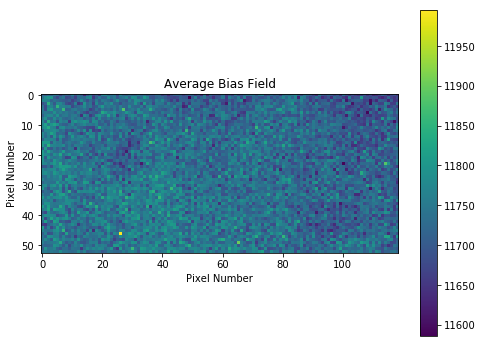

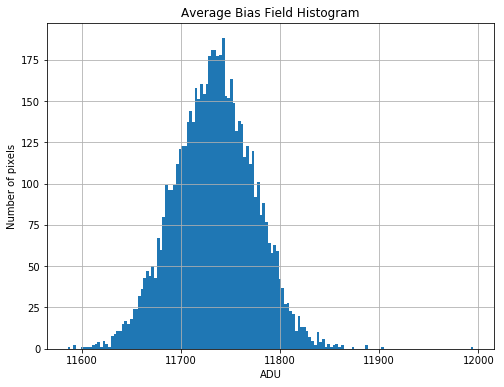

Mean Bias Value (ADU): 11733.2866656


In [3]:
bias = []
bias_sum = np.zeros((height,width))
for i in range(1,11):
    biasname = 'bias.' + str(i) + '.fit'
    biasdata = fits.getdata(biasname)
    bias.append(biasdata.astype(np.int))
    bias_sum = bias_sum + biasdata

avgbias = (bias_sum)/len(bias)

plt.figure(figsize=(8,6))
plt.xlabel('Pixel Number')
plt.ylabel('Pixel Number')
plt.title('Average Bias Field')
plt.imshow(avgbias)
plt.colorbar()
plt.show()

plt.figure(figsize=(8,6))
plt.hist(avgbias.flatten(),bins=150)
plt.title('Average Bias Field Histogram')
plt.xlabel('ADU')
plt.ylabel('Number of pixels')
plt.grid(True)
plt.show()

print ('Mean Bias Value (ADU):',np.mean(avgbias))

From the color map it is clear that most of the pixels shares similar ADU intensities. It appears as though there is just one inaccurate pixel, at a location of approximately 25,48. This peak in intensity can also be seen in the histogram- just below 12000 ADU. In actual fact it is not too much greater than the average peak intensity of about 11733 ADU, but its difference could potentially be attributed to a hot pixel.

Now the signal frames are imported. 10 exposure times were taken, starting at 0.1s incramenting by 0.1s each time. At each exposure time 5 images were taken. The code starts by creating an average signal array for each exposure time from the five images of each time, whilst subtracting the average bias frame from each signal frame. (This however has been done from each pixel rather than the mean as a whole, to get a more accurate result.) The standard deviation is calculated from the 5 pixel ADU values at a specific pixel location in the 5 trials for one exposure time. This loops to create a standard deviation array that calculates the standard deviation at every pixel location for one particular exposure time. This then further loops for each different exposure time, creating a master standard deviation array, that contains individual standard deviation arrays from each exposure time. Squaring the standard deviation at each pixel location provides the variance of the data- this is output into another array. Overall this code produces three 3D arrays: the average signal array at each exposure time, the standard deviation array at each exposure time, and the variance array at each exposure time.

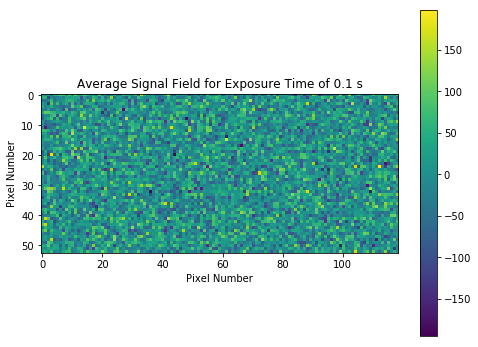

Mean Signal Count (Exposure time= 0.1): 5.36207388616


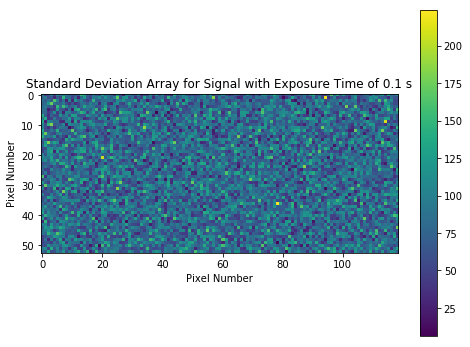

Mean Standard Deviation (Exposure time= 0.1): 82.6945773305


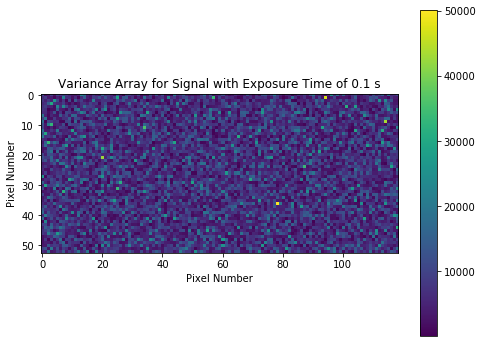

Mean Variance (Exposure time= 0.1): 7725.85661646


In [15]:
signal_avgarray = []
std_array = []
var_array = []

for name in ['signal1','signal2','signal3','signal4','signal5','signal6','signal7','signal8','signal9','signal10']:
    signal = []
    signal_sum = np.zeros((height,width))
    stdarr = np.zeros((height,width))
    vararr = np.zeros((height,width))
    for i in range(1,6):
        signame = name + '.0000000' + str(i) + '.fit'
        sigdata = fits.getdata(signame).astype(np.int) - avgbias
        signal.append(sigdata)
        signal_sum = signal_sum + sigdata
    for h in range(height):
        for w in range(width):
            pix_values = [arr[h,w] for arr in signal]
            pix_values = np.array(pix_values)
            stdarr[h,w] = pix_values.std()
            vararr[h,w] = (stdarr[h,w])**2
    avgsignal = signal_sum/len(signal)
    std_array.append(stdarr)
    var_array.append(vararr)
    signal_avgarray.append(avgsignal) 
    
def signalinfo(t): # pick a number from 1 to 5, where 1 is 0.1s exposure time and so on.
    n = t - 1
    plt.figure(figsize=(8,6))
    plt.imshow(signal_avgarray[n])
    plt.colorbar()
    plt.title('Average Signal Field for Exposure Time of 0.%s s' %(t))
    plt.xlabel('Pixel Number')
    plt.ylabel('Pixel Number')
    plt.show()

    print ('Mean Signal Count (Exposure time= 0.%s):' %(t),np.mean(signal_avgarray[n]))

    plt.figure(figsize=(8,6))
    plt.imshow(std_array[n])
    plt.colorbar()
    plt.title('Standard Deviation Array for Signal with Exposure Time of 0.%s s' %(t))
    plt.xlabel('Pixel Number')
    plt.ylabel('Pixel Number')
    plt.show()
    print ('Mean Standard Deviation (Exposure time= 0.%s):' %(t),np.mean(std_array[n]))

    plt.figure(figsize=(8,6))
    plt.imshow(var_array[n])
    plt.colorbar()
    plt.title('Variance Array for Signal with Exposure Time of 0.%s s' %(t))
    plt.xlabel('Pixel Number')
    plt.ylabel('Pixel Number')
    plt.show()
    print ('Mean Variance (Exposure time= 0.%s):' %(t),np.mean(var_array[n]))
    
signalinfo(1)

By plotting the signal against the variance, the diversity of gain values for one particular exposure time can be seen. The scatter plot shows just how diverse each pixel's gain is.

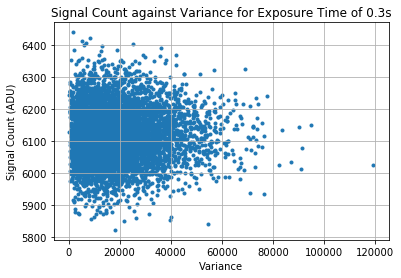

In [5]:
plt.scatter((var_array[2]),signal_avgarray[2],marker='.')
plt.xlabel('Variance')
plt.ylabel('Signal Count (ADU)')
plt.title('Signal Count against Variance for Exposure Time of 0.3s')
plt.grid(True)
plt.show()

The mean value of the signal and variance can be taken from each array for each exposure time in a loop, as shown in the code below. The result provides a single array of mean signal values from each exposure time, and a single array of mean variance values. These two arrays are then plotted against each other.

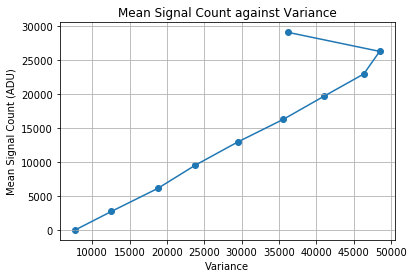

In [6]:
mean_signal = []
mean_var = []
for i in range(10):
    data = np.mean(signal_avgarray[i])
    data2 = np.mean(var_array[i])
    mean_signal.append(data)
    mean_var.append(data2)
    
plt.scatter(mean_var,mean_signal)
plt.plot(mean_var,mean_signal)
plt.xlabel('Variance')
plt.ylabel('Mean Signal Count (ADU)')
plt.title('Mean Signal Count against Variance')
plt.grid(True)
plt.show()

It is clear that all the data points follow a linear relationship, with the exception of the last data point, which from here onwards will be excluded in calculating the gain.

Now an estimate of the gain can be calculated. To do so, a gainset is determined, which takes the average signal values in ADU of a particular exposure time at each pixel, and divides it with the average variance value at that exposure time (as per the equation given above) at each pixel. This loops over all exposure times, providing 10 values for the gain, one at each exposure time. As per above, the last frame will be excluded in this measurement as it does not follow the same trend as the other data. The code prints the mean value of the gain from the 9 data samples.

In [7]:
gainset = []
for g in range(10):
    gain = signal_avgarray[g]/(var_array[g])
    gainset.append(gain)
    
print (len(gainset))
print (gainset[0].shape)
gain = np.mean(gainset[0:9])
print ('Average Gain:', gain)

10
(53, 119)
Average Gain: 0.751461858334


Finally the read noise can be calculated using the method and equation described in the theory section. However, instead of just taking the difference of one frame, all are differenced from the first one, creating an array of read noises, but then averaged into a more accurate final read noise.

In [16]:
readnoiseset = []
readnoisesum = 0
for i in range(1,10):
    stdbias = np.std(bias[0] - bias[i])
    readnoise = (gain * stdbias)/(np.sqrt(2))
    readnoisesum = readnoise + readnoisesum
    readnoiseset.append(readnoise)
avgreadnoise = readnoisesum/len(readnoiseset)
    
print ('Read Noise:',avgreadnoise)

Read Noise: 73.8052468845


#### Part 2: Dark Frame Analysis

In this section of code, the dark count in ADU is tested against a variation of the CCD temperature. At 5 different temperatures (-4,-7,-10,-13,-16 degrees C), two dark frames were taken with an exposure time of 20 seconds each. the two frames for each temperature were averaged into one dark frame, and all five frames are stored in 'dark_framset' below. 10 bias frames were taken at each temperature. These were then averaged into one dark frame at each temperature, and all five frames then stored in the 'darkbias_frameset'. Finally the bias subtracted dark frames are calculated and stored in 'dark_biassub_frameset' for each temperature. Using the function 'darkinfo' below allows the reader to see the average dark frame, bias frame, and bias subtracted dark frame, as well as the mean value of each frame at one of the temperatures.

[4, 7, 10, 13, 16]
[269, 266, 263, 260, 257]


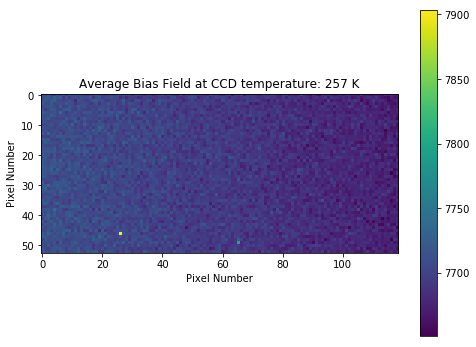

Mean Bias Count: 7693.67873439


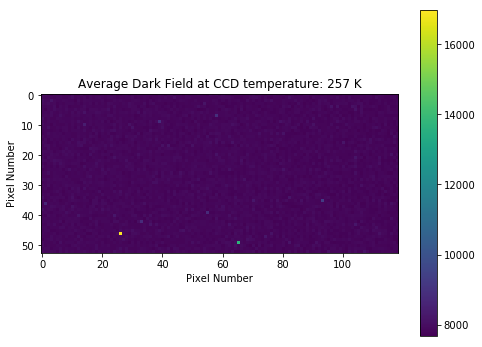

Mean Dark Count: 7845.77953068


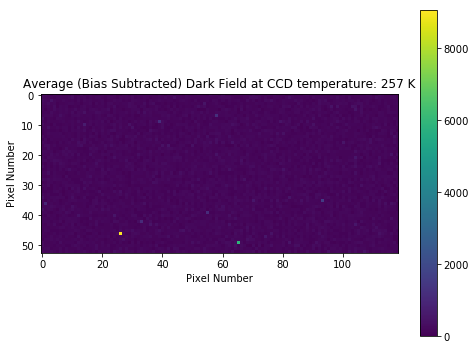

Mean Bias Subtracted Dark Count: 152.100796293


In [14]:
temps = [4,7,10,13,16]

darkbias_frameset = []
for temp in (temps):
    darkbias = []
    darkbias_sum = np.zeros((height,width))
    for i in range(1,10):
        darkbiasdata = fits.getdata('dark_bias' + str(temp) + '.0000000' + str(i) + '.HIP 79622.Bias.fit').astype(np.int)
        darkbias.append(darkbiasdata)
        darkbias_sum = darkbias_sum + darkbiasdata
    avgdarkbias = darkbias_sum/len(darkbias)
    darkbias_frameset.append(avgdarkbias)

dark_frameset = []
for i in (temps):
    dark_frame1 = fits.getdata('dark_' + str(i) + '.00000001.HIP 79622.Dark.fit').astype(np.int)
    dark_frame2 = fits.getdata('dark_' + str(i) + '.00000002.HIP 79622.Dark.fit').astype(np.int)
    dark_frame = (dark_frame1+dark_frame2)/2
    dark_frameset.append(dark_frame)    

dark_biassub_frameset = []
for i in range(5):
    dark_biassub = dark_frameset[i] - darkbias_frameset[i]
    dark_biassub_frameset.append(dark_biassub)

temps_kel = [(temp*(-1) + 273) for temp in (temps)]
print (temps)
print (temps_kel)  

def darkinfo(t): # choose value from 0 to 4, where 0 is -4 degrees C, 1 is -7 degrees C and so on
    T = 4 + 3*t  
    T_k = -(T) + 273
    
    plt.figure(figsize=(8,6))
    plt.imshow(darkbias_frameset[t])
    plt.colorbar()
    plt.title('Average Bias Field at CCD temperature: %s K' %(T_k))
    plt.xlabel('Pixel Number')
    plt.ylabel('Pixel Number')
    plt.show()
    print ('Mean Bias Count:', np.mean(darkbias_frameset[t])) 

    plt.figure(figsize=(8,6))
    plt.imshow(dark_frameset[t])
    plt.colorbar()
    plt.title('Average Dark Field at CCD temperature: %s K' %(T_k))
    plt.xlabel('Pixel Number')
    plt.ylabel('Pixel Number')
    plt.show()
    print ('Mean Dark Count:', np.mean(dark_frameset[t]))

    plt.figure(figsize=(8,6))
    plt.imshow(dark_biassub_frameset[t])
    plt.colorbar()
    plt.title('Average (Bias Subtracted) Dark Field at CCD temperature: %s K' %(T_k))
    plt.xlabel('Pixel Number')
    plt.ylabel('Pixel Number')
    plt.show()
    print ('Mean Bias Subtracted Dark Count:', np.mean(dark_biassub_frameset[t]))
    
darkinfo(4)

With each bias subtracted dark, the mean ADU value is calculated for each frame. This can be plotted against the Temperature of the CCD.

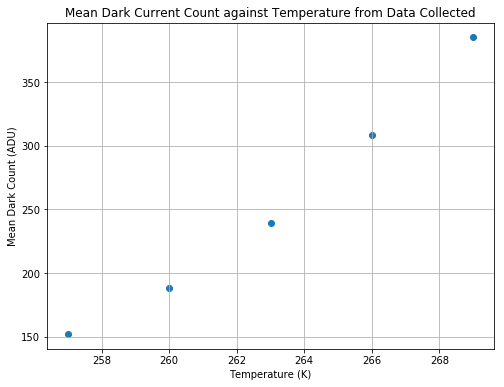

[384.99585997921184, 308.55337984250303, 239.47066751228795, 188.02964959568735, 152.1007962933601]
[269, 266, 263, 260, 257]


In [10]:
darkmeans = [np.mean(dark_biassub_frameset[i]) for i in range(5)]

plt.figure(figsize=(8,6))
plt.scatter(temps_kel,darkmeans)
plt.xlabel('Temperature (K)')
plt.ylabel('Mean Dark Count (ADU)')
plt.grid(True)
plt.title('Mean Dark Current Count against Temperature from Data Collected')
plt.show()

print (darkmeans)
print (temps_kel)

Using the equation given in the theory section, an analytical solution can be determined for each of the temperatures.

A = 13920830.324, Eg = 0.875589969097
[  2.54717851e+13   8.37180335e+04] [  8.37180335e+04   2.75210374e-04]


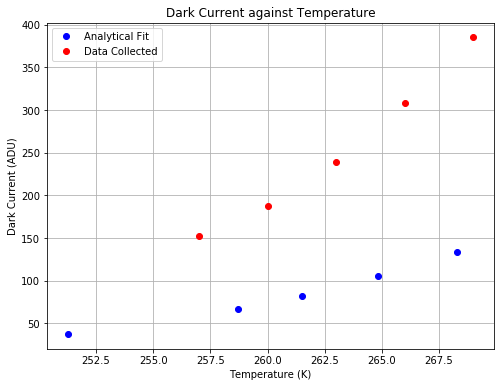

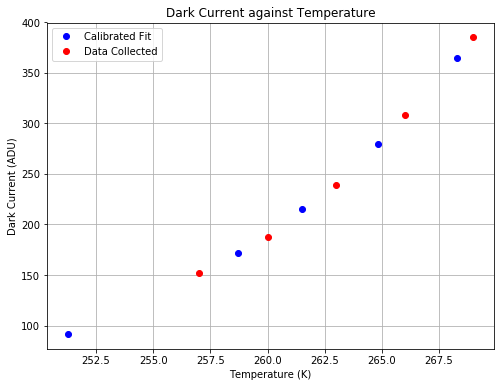

In [13]:
# Constants and values
k = 8.617E-05 # in eV/K

def darkeq(T,A,Eg):
    return (A*(T**1.5)*np.exp(-Eg/(2*k*T)))

a,eg = (10**6,0.8)

T, D = (np.array(temps_kel),np.array(darkmeans))

Tmin, Tmax = (250,270)
Tvals = np.random.uniform(Tmin,Tmax,5)
Dvals = darkeq(Tvals,a,eg)

coeffs, fiterr = curve_fit(darkeq, T, D, p0=(a,eg),maxfev=1000)
print ('A = %s, Eg = %s' % (coeffs[0],coeffs[1]))
print (fiterr[0],fiterr[1])

plt.figure(figsize=(8,6))
plt.plot(Tvals,Dvals,'bo',label='Analytical Fit')
plt.plot(T,D,'ro',label='Data Collected')
plt.title('Dark Current against Temperature')
plt.xlabel('Temperature (K)')
plt.ylabel('Dark Current (ADU)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(Tvals,darkeq(Tvals,*coeffs),'bo',label='Calibrated Fit')
plt.plot(T,D,'ro',label='Data Collected')
plt.title('Dark Current against Temperature')
plt.xlabel('Temperature (K)')
plt.ylabel('Dark Current (ADU)')
plt.legend()
plt.grid(True)
plt.show()

After the intial estimate is made, the curve_fit tools more accurately calculates the values for $A$ and $E_g$ which can are:

$ A = {1.39}\times{10^7} ADU pixel^{-1} s^{-1} $

$ E_g = 0.876 eV $.

Literature values suggest $ E_g(Si) = 1.11eV^{[1]} $. Even considering the error of the curve fit, the value obtained by the curve fit is not accurate to the literature value, although it is of order magnitude.

### Conclusion

This notebook provides a useful way to code and average bias, flat, and dark frames from the Angell Hall Telescope. Each of the loops given above can indeed be writen into functions, where the user inputs the images and the function returns the averages, standard deviations, variances, gainsets etc. The method used to calcualte gain was indeed accurate: multiple bias frames were taken and averaged; and each and every pixel's standard deviation and variance was calculated in the 10 signals. This allowed for the calculation of a different gain value at each and every pixel location in all 10 signals. The average gain could then be calculated using all this data. Taking this approach also led us to find that the last signal taken (1.0s) was anomalous to the other results and did not follow the same trend. This enabled us to disregard that data point, and obtain a more accurate gain. 

The data collected from the dark frames did follow the same trend as that suggested by the dark current equation, with respect to the temperature of teh CCD. Using this data enabled us to calculate the constants in that equation, which provided a good estimate to real values despite not being accurate to literature values, even when considering the errors in the curve fit. There are a few ways to improve this experiment to obtain more accurate answers: taking more measurements (e.g. more exposures to average, taking frames with a smaller temperature interval), and using a CCD with greater pixel dimensions. Of course the time limit on the telescope is of the greatest concern when taking multiple measurements and must be carefully planned to have enough time for taking real astronomical images.

### Appendix

[1] Streetman, Ben G.; Sanjay Banerjee (2000). Solid State electronic Devices (5th ed.). New Jersey: Prentice Hall. p. 524. ISBN 0-13-025538-6.